In [1]:
%matplotlib inline
import numpy as np
import camb
import os
from camb import model, initialpower
import matplotlib
import matplotlib.pyplot as plt
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.0.6 installed at /Users/panz/Code/anaconda3/anaconda3/lib/python3.7/site-packages/camb


## Introduction to cosmological parameters

## Zhaodi Pan

This notebook basically uses CAMB to explore the effect of cosmological parameters on the CMB and explain why there are certain changes. 

The Standard Model of Cosmology ($\Lambda CDM$ model) assumes the universe started from a hot big bang and compose of 5\% baryon matter, 27\% dark matter, and 68\% dark energy. The theory of general relativity governs the expansion of space in a homogeneous model of the universe. Specifically, we can write down Friedmann equation that governs the expansion of the universe in the context of general relativity. 

\begin{equation}
H(a) =  \frac {\dot a} a = H_0 \sqrt{\Omega_m a^{-3} + \Omega_r a^{-4} + \Omega_k a^{-2} + \Omega_{\Lambda} a^{-3(1+w)}}
\end{equation} 

A flat $\Lambda CDM$ model with six cosmological parameters assumes the universe is flat, or $\Omega_K =0$. The six parameters are baryon density $\Omega_b h^2$, cold dark matter density $\Omega_c h^2$, optical depth $\tau$, angular size of the sound horizon at recombination $\theta_{MC}$, the amplitude of primordial scalar fluctuation $A_s$, and the spectral index of primordial scalar fluctuation $n_s$. The temperature spectrum measured by Planck fits well to the six-parameter $\Lambda CDM$ model. There are additional important parameters that can be probed by the CMB, including curvature of the universe $\Omega_K$, acoustic oscillation angular scale on the sky $\theta ^*$, Hubble constant $H_0$, the sum of neutrino mass $\Sigma m_{\nu}$, number of relativitistic species $N_{eff}$, tensor-to-scalar ratio $r$, and lensing amplitude $A_{lens}$. 

In [2]:
def calculate_cmb(
    H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, 
    tau=0.06, As=2e-9, ns=0.965, r=0, lmax=3000, max_l_tensor=3000,
    lens_potential_accuracy =0, thetastar=None,Alens=1, 
    Neff = 3.046, WantTensors=True):
    # initialize camb parameter, no tensor here
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=omk, 
                       tau=tau, nnu=3.046, thetastar=thetastar, Alens=Alens)
    pars.num_nu_massless = Neff
    #no tensor yet, set r=0 here, calculate inflation B mode separately
    pars.InitPower.set_params(As=As, ns=ns, r=0)
    pars.set_for_lmax(lmax, lens_potential_accuracy=lens_potential_accuracy)
    pars.max_l_tensor=max_l_tensor
    #calculate results for these parameters
    results = camb.get_results(pars)
    powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
    # return the parameter, results, and power
    return {'pars': pars, 'results': results, 'power': powers}

def calculate_tensor(pars, ns=0.965, r=0.1, lmax=3000):
    # calculate the inflationary B mode
    pars.WantTensors = True
    pars.max_l_tensor = lmax
    trans = camb.get_transfer_functions(pars)
    inflation_params = initialpower.InitialPowerLaw()
    inflation_params.set_params(ns=ns, r=r)
    trans.power_spectra_from_transfer(inflation_params) #warning OK here, not changing scalars
    cl_tensor = trans.get_tensor_cls(lmax, CMB_unit='muK')
    return cl_tensor

## Spatial curvature
First of all, before assuming flat $\Lambda CDM$ cosmology, let's explore the impact of spatial curvature on the CMB power spectra. Curvature of the universe means non-zero $\Omega_K$. How does $\Omega_K$ affects the power spectrum? 

Let's think about a closed universe. In a closed universe things look as if they are closer (see figure below). So the same length viewed from the same cordinate distance away will appear at a larger angle. Therefore, the features in CMB spectra will shift to larger angular scales or smaller $\ell$. Similarly, for an open universe, the CMB features will shift to higher $\ell$. $\Omega_K$>0 indicates a open universe, therefore things should shift to the right (see plot below). 

In almost all plots below, top are TT spectra with varied parameters and bottom are EE spectra.

<img src="Universe_curvature.png" alt="Drawing" style="width: 500px;"/>
Figure credit: Wayne Hu

No handles with labels found to put in legend.


Text(0, 0.5, '$\\ell (\\ell+1) C_\\ell / 2\\pi$ ($\\mu$K$^2$)')

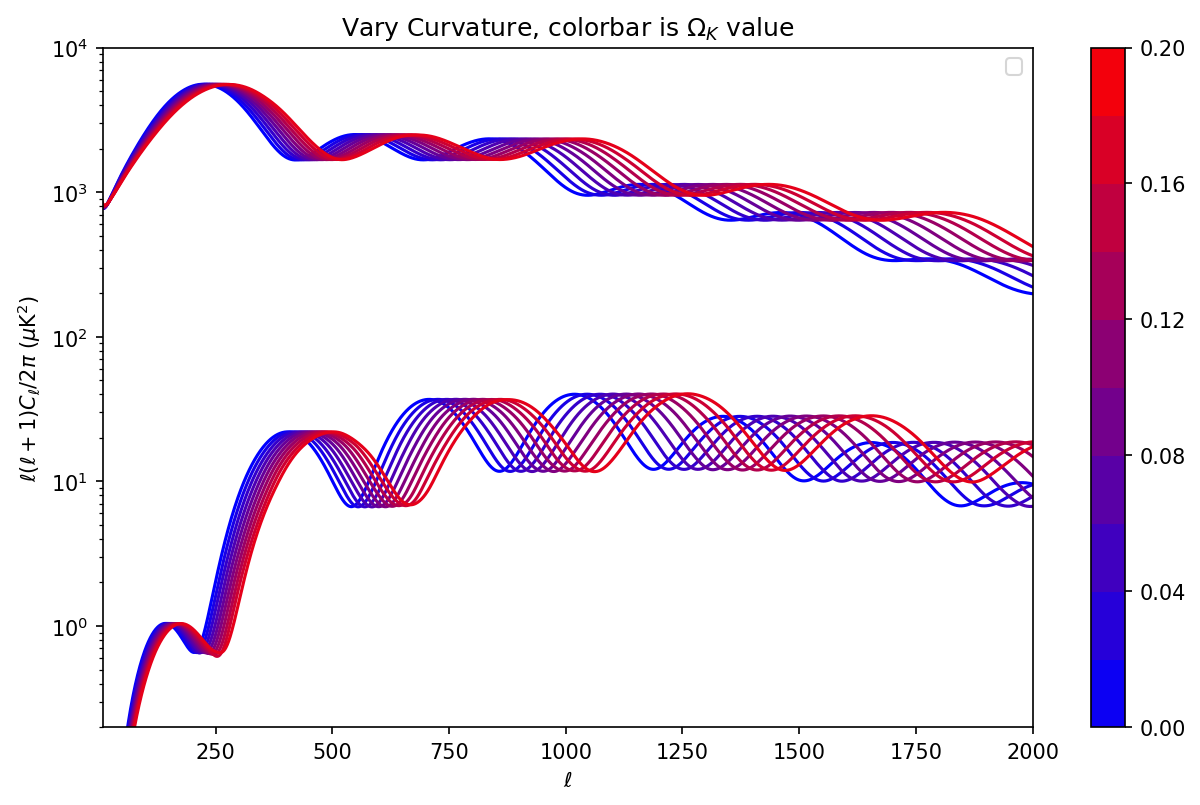

In [3]:
# step through omegak from 0 to 0.2 in 10 steps
min_par = 0
max_par = 0.2
stepsize = 0.02
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])

# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = np.arange(min_par,max_par+stepsize,stepsize)
plt.figure(figsize= (10,6), dpi = 150)
CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()
# real plotting start here. 
for par in np.arange(min_par, max_par, stepsize):
    camb_results = calculate_cmb(omk = par)
    totCL = camb_results['power']['total']
    refCL = camb_results['results'].get_lensed_scalar_cls(CMB_unit='muK')
    r = (par-min_par)/(max_par-min_par)
    g = 0
    b = 1-r
    ells = np.arange(len(totCL[:,0]))
    plt.semilogy(ells,totCL[:,0], color=(r, g, b) )
    plt.semilogy(ells,totCL[:,1], color=(r, g, b) )
plt.colorbar(CS3)
plt.axis([8,2000, 2e-1, 1e4])
plt.legend(ncol=2, loc='best')
plt.title('Vary Curvature, colorbar is $\Omega_K$ value')
plt.xlabel('$\ell$' )
plt.ylabel('$\ell (\ell+1) C_\ell / 2\pi$ ($\mu$K$^2$)')

## Baryon density

In the universe before recombination, photons and baryons are tightly coupled together, forming a plasma. Starting from the initial condition, the photon-baryon fluid tend to fall into the gravitational potential wells and compress itself. However, as the infall happens, photon pressure will increase and then rarefy the fluid. It's like a spring. Gravity provides the attraction force and photon pressure provides the repulsion force. 

The first CMB peak correspond to the mode that are just able to finish a compression or half of the oscillation cycle before recombination. The second peak correspond to the mode that just finished one complete compression-rarefication cycle.

If the baryon density is increased, the inertia of the fluid is also higher, and they'll fall into the potential wells harder. This will lead to stronger compressions (odd number of peaks) and weaker rarefactions (even number of peaks). Looking at the plot made below, the first peak becomes higher than the second peak as baryon density increases, and the contrast between odd peaks and even peaks increases.

Note that in the plot below, $\Omega_b h^2$, or the physical density, is varied because the critical density depends on the Hubble constant. 

The bottom plots are EE spectra. Note that E-modes are generated by Thomson scattering of local quadrupole, whose largest contribution comes from Doppler shifts induced by the velocity field of the fluid. Therefore, E-mode peaks are out of phase with T-mode phase. In the oscillating spring analogy, T peaks are where the spring is at maximum compression or stretch, while E peaks are at maximum velocity of the spring. Since local quadrupole comes from diffusion of photons from different temperatures, which only happens more right before recombination as the mean-free path increases, E-mode is weaker than temperature. And large scales of the E-mode is small because photons cannot diffuse very far. 

Note that as baryon density increases, the first peak increases and the second peak decreases in the E mode for the same reason as temperature. 

<img src="plasma_oscillator.png" alt="Drawing" style="width: 400px;"/>

Credit: Wayne Hu

No handles with labels found to put in legend.


Text(0, 0.5, '$\\ell (\\ell+1) C_\\ell / 2\\pi$ ($\\mu$K$^2$)')

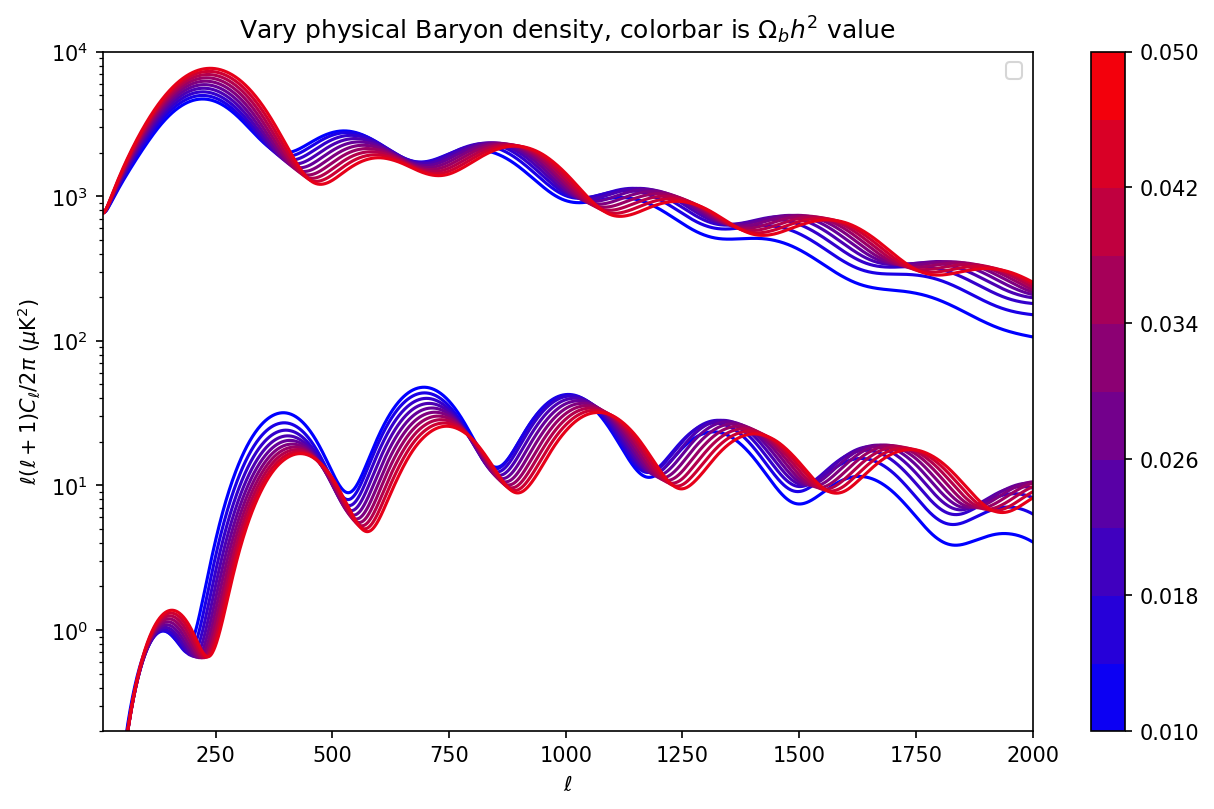

In [4]:
# step through baryon physical density
min_par = 0.01
max_par = 0.05
stepsize = 0.004
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])

# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = np.arange(min_par,max_par+stepsize,stepsize)
plt.figure(figsize= (10,6), dpi = 150)
CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()
# real plotting start here. 
for par in np.arange(min_par, max_par, stepsize):
    camb_results = calculate_cmb(ombh2 = par)
    totCL = camb_results['power']['total']
    refCL = camb_results['results'].get_lensed_scalar_cls(CMB_unit='muK')
    r = (par-min_par)/(max_par-min_par)
    g = 0
    b = 1-r
    ells = np.arange(len(totCL[:,0]))
    plt.semilogy(ells,totCL[:,0], color=(r, g, b) )
    plt.semilogy(ells,totCL[:,1], color=(r, g, b) )
plt.colorbar(CS3)
plt.axis([8,2000, 2e-1, 1e4])
plt.legend(ncol=2, loc='best')
plt.title('Vary physical Baryon density, colorbar is $\Omega_b h^2$ value')
plt.xlabel('$\ell$' )
plt.ylabel('$\ell (\ell+1) C_\ell / 2\pi$ ($\mu$K$^2$)')

## Dark matter density

If there is less dark matter, the portion of radiation in all matter will become larger. For a universe which is photon dominated, its mass or gravitational potential will also be dominated by the photon-baryon fluid instead of the dark matter background potential. Therefore, as the fluid finishes the first compression and rarefy, the potential well generated by the fluid itself is no longer there, and the oscillation amplitude will be much bigger, because there is less gravity pulling the fluid back. With less dark matter, the oscillation will be stronger and the power spectrum amplitude will increase. Since the even number peaks correspond to modes that finishes rarefication at the time of recombination, less dark matter will result in stronger even number peaks and an overall amplitude increase. On the other hand, a strong third (odd) peak (compared to the second (even number) peak) means more dark matter. 

Both the baryon density and dark matter density change the oscillation period and shifts the peaks. 

No handles with labels found to put in legend.


Text(0, 0.5, '$\\ell (\\ell+1) C_\\ell / 2\\pi$ ($\\mu$K$^2$)')

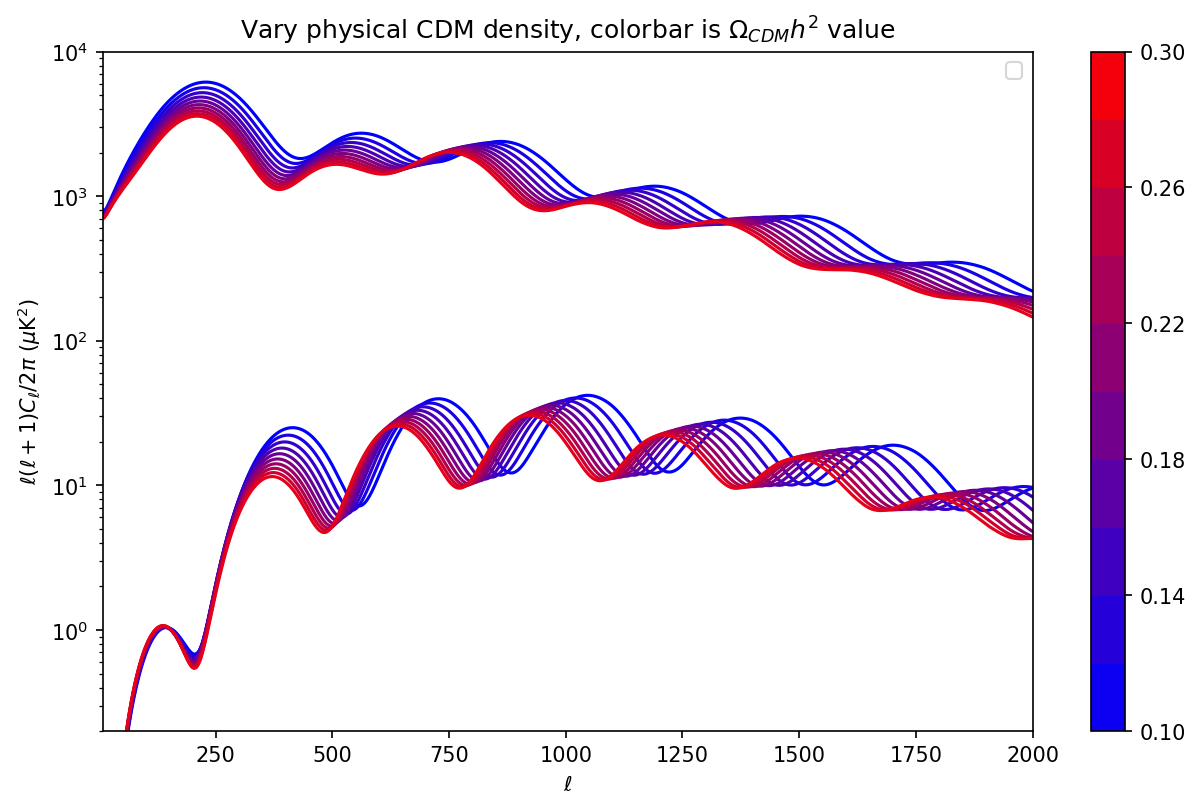

In [5]:
# step through cold dark matter physical density from 0 to 1 in 5 steps
min_par = 0.1
max_par = 0.3
stepsize = 0.02
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])

# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = np.arange(min_par,max_par+stepsize,stepsize)
plt.figure(figsize= (10,6), dpi = 150)
CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()
# real plotting start here. 
for par in np.arange(min_par, max_par, stepsize):
    camb_results = calculate_cmb(omch2 = par)
    totCL = camb_results['power']['total']
    refCL = camb_results['results'].get_lensed_scalar_cls(CMB_unit='muK')
    r = (par-min_par)/(max_par-min_par)
    g = 0
    b = 1-r
    ells = np.arange(len(totCL[:,0]))
    plt.semilogy(ells,totCL[:,0], color=(r, g, b) )
    plt.semilogy(ells,totCL[:,1], color=(r, g, b) )
plt.colorbar(CS3)
plt.axis([8,2000, 2e-1, 1e4])
plt.legend(ncol=2, loc='best')
plt.title('Vary physical CDM density, colorbar is $\Omega_{CDM} h^2$ value')
plt.xlabel('$\ell$' )
plt.ylabel('$\ell (\ell+1) C_\ell / 2\pi$ ($\mu$K$^2$)')

## Tau

The reionization optical depth $\tau$ affects the overall amplitude of the CMB spectrum. Free electrons generated during reionization can scatter CMB photons via Thomson scattering. If the optical depth is larger, the CMB will be attenuated more before they can reach us. Measuring the optical depth can help us constrain reionization. 

No handles with labels found to put in legend.


Text(0, 0.5, '$\\ell (\\ell+1) C_\\ell / 2\\pi$ ($\\mu$K$^2$)')

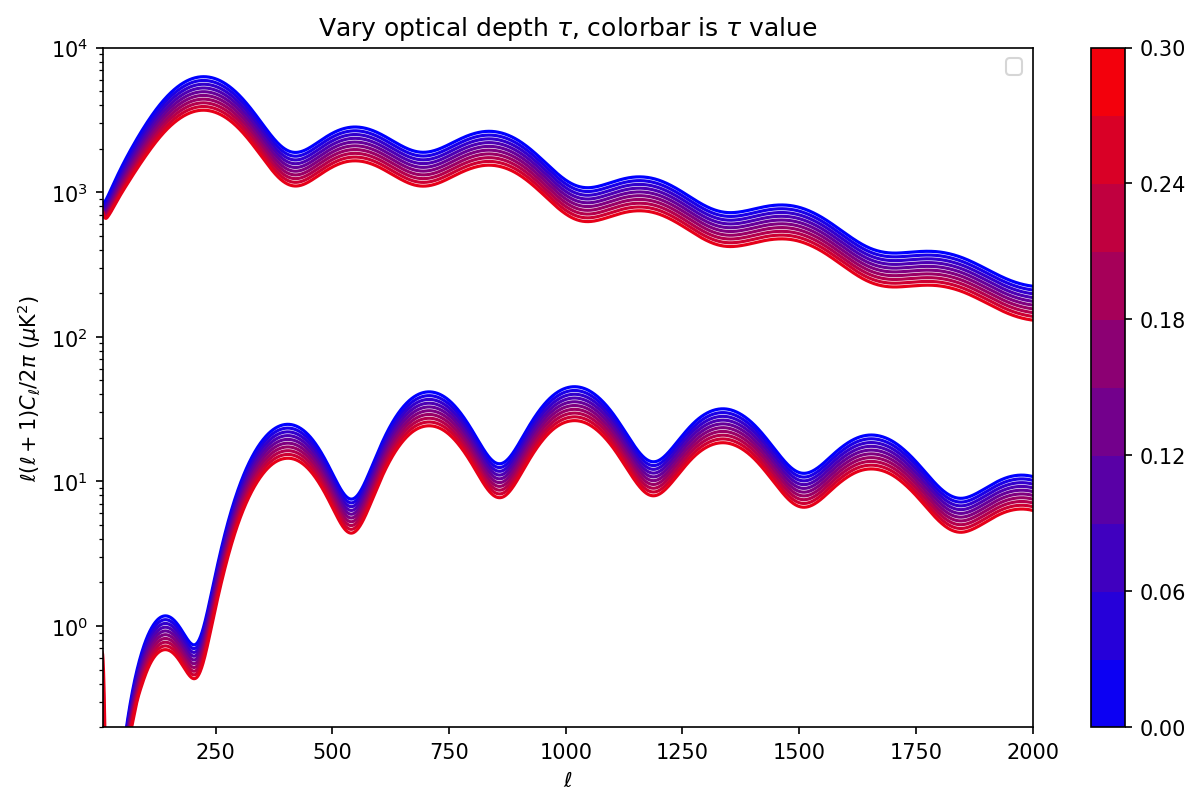

In [6]:
# step through tau 
min_par = 0
max_par = 0.3
stepsize = 0.03
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])

# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = np.arange(min_par,max_par+stepsize,stepsize)
plt.figure(figsize= (10,6), dpi = 150)
CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()
# real plotting start here. 
for par in np.arange(min_par, max_par, stepsize):
    camb_results = calculate_cmb(tau = par)
    totCL = camb_results['power']['total']
    refCL = camb_results['results'].get_lensed_scalar_cls(CMB_unit='muK')
    r = (par-min_par)/(max_par-min_par)
    g = 0
    b = 1-r
    ells = np.arange(len(totCL[:,0]))
    plt.semilogy(ells,totCL[:,0], color=(r, g, b) )
    plt.semilogy(ells,totCL[:,1], color=(r, g, b) )
plt.colorbar(CS3)
plt.axis([8,2000, 2e-1, 1e4])
plt.legend(ncol=2, loc='best')
plt.title('Vary optical depth $\\tau$, colorbar is $\\tau$ value')
plt.xlabel('$\ell$' )
plt.ylabel('$\ell (\ell+1) C_\ell / 2\pi$ ($\mu$K$^2$)')

## Primordial scalar power spectrum
The CMB structure seeded from adiabatic primordial scalar curvature perturbations.
\begin{equation}
P_R(k) = A_s(\frac{k}{k_*})^{n_s - 1 + \frac 1 2 dn_s/d ln k ln(k/k_*)}
\end{equation}

Here $A_s$ is the amplitude, and $n_s$ is the spectral index. The second order term in the exponent is the running of the spectral index. $k_*$ is the pivot scale. 

$A_s$ will affect the overall amplitude of the CMB spectra. It's degenerate with optical depth, and $A_s e^{-2\tau}$ can be constrained better than $A_s$ or $\tau$ individually. 

The τ–As degeneracy can be broken using CMB along with CMB lensing, or by combining with external data on largescale structure, both of which constrain $A_s$.

No handles with labels found to put in legend.


Text(0, 0.5, '$\\ell (\\ell+1) C_\\ell / 2\\pi$ ($\\mu$K$^2$)')

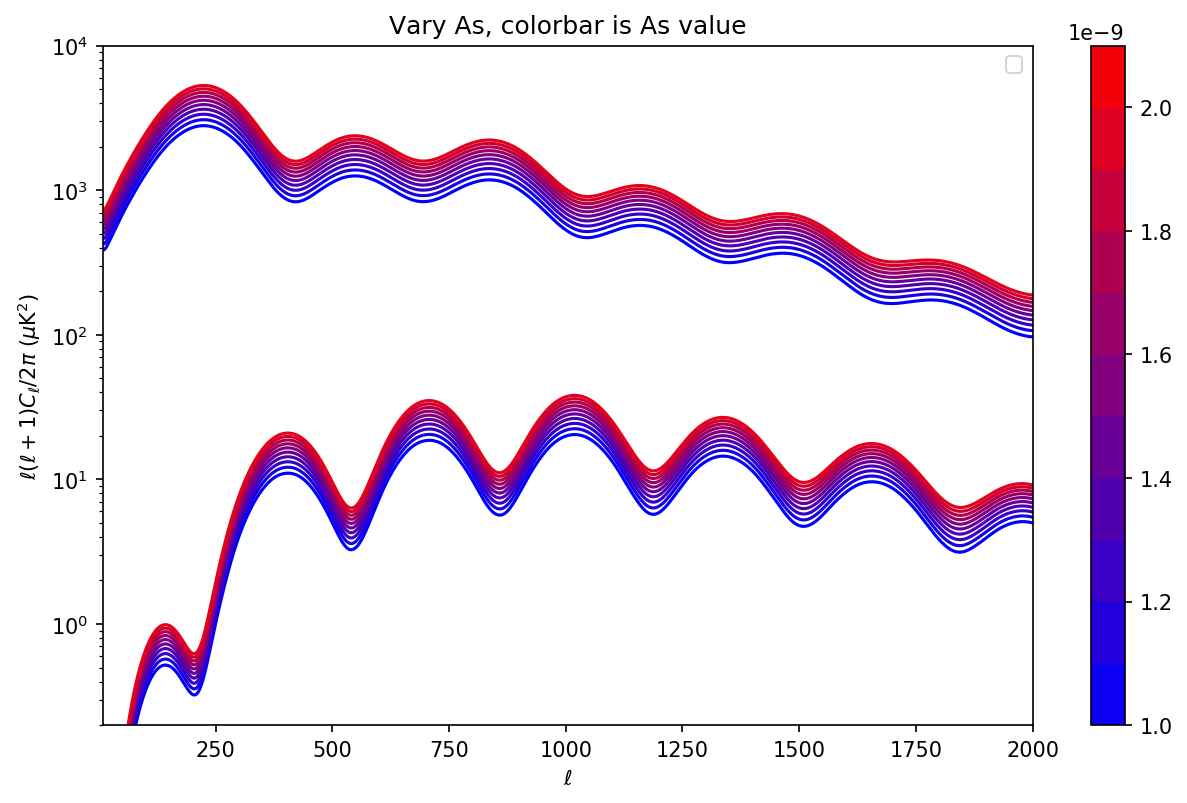

In [7]:
# step through As 
min_par = 1e-9
max_par = 2e-9
stepsize = 1e-10
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])

# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = np.arange(min_par,max_par+stepsize,stepsize)
plt.figure(figsize= (10,6), dpi = 150)
CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()
# real plotting start here. 
for par in np.arange(min_par, max_par, stepsize):
    camb_results = calculate_cmb(As = par)
    totCL = camb_results['power']['total']
    refCL = camb_results['results'].get_lensed_scalar_cls(CMB_unit='muK')
    r = (par-min_par)/(max_par-min_par)
    g = 0
    b = 1-r
    ells = np.arange(len(totCL[:,0]))
    plt.semilogy(ells,totCL[:,0], color=(r, g, b) )
    plt.semilogy(ells,totCL[:,1], color=(r, g, b) )
plt.colorbar(CS3)
plt.axis([8,2000, 2e-1, 1e4])
plt.legend(ncol=2, loc='best')
plt.title('Vary As, colorbar is As value')
plt.xlabel('$\ell$' )
plt.ylabel('$\ell (\ell+1) C_\ell / 2\pi$ ($\mu$K$^2$)')

## $n_s$

As discussed above, $n_s$ is the spectral index of the fluctuation. It determines the "tilt" of the CMB power spectrum. With a larger $n_s$, CMB spectra will be higher above the pivot scale and lower below the pivot scale. 

No handles with labels found to put in legend.


Text(0, 0.5, '$\\ell (\\ell+1) C_\\ell / 2\\pi$ ($\\mu$K$^2$)')

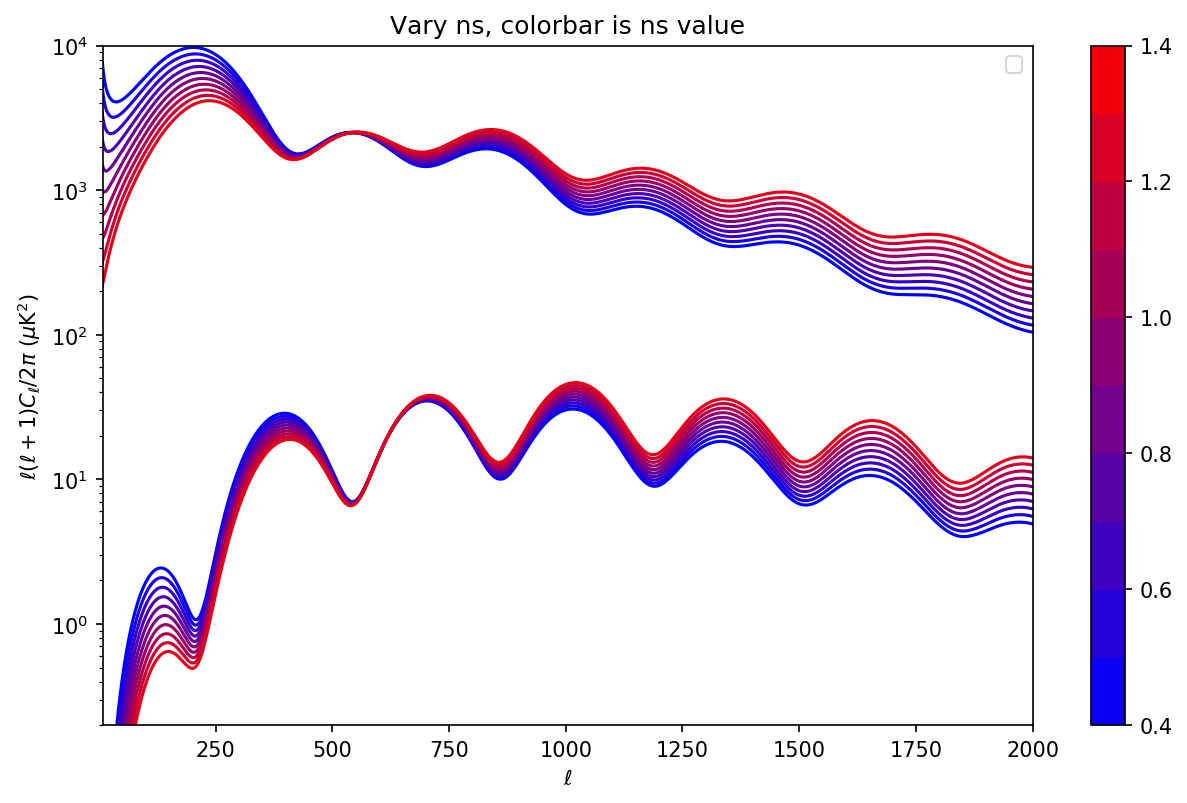

In [8]:
# step through ns 
min_par = 0.4
max_par = 1.4
stepsize = 0.1
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])

# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = np.arange(min_par,max_par+stepsize,stepsize)
plt.figure(figsize= (10,6), dpi = 150)
CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()
# real plotting start here. 
for par in np.arange(min_par, max_par, stepsize):
    camb_results = calculate_cmb(ns = par)
    totCL = camb_results['power']['total']
    refCL = camb_results['results'].get_lensed_scalar_cls(CMB_unit='muK')
    r = (par-min_par)/(max_par-min_par)
    g = 0
    b = 1-r
    ells = np.arange(len(totCL[:,0]))
    plt.semilogy(ells,totCL[:,0], color=(r, g, b) )
    plt.semilogy(ells,totCL[:,1], color=(r, g, b) )
plt.colorbar(CS3)
plt.axis([8,2000, 2e-1, 1e4])
plt.legend(ncol=2, loc='best')
plt.title('Vary ns, colorbar is ns value')
plt.xlabel('$\ell$' )
plt.ylabel('$\ell (\ell+1) C_\ell / 2\pi$ ($\mu$K$^2$)')

## The acoustic angular scale

The acoustic angular scale is defined as $\theta_* = r_*/D_M$, where $r_*$ is the comoving sound horizon at recombination, and $D_M$ is the comoving angular diameter distance. 

The acoustic angular scale is actually measured really well by the peak position even independent of cosmology, so it shouldn't vary at all. Its variation is not very interesting, and CAMB basically adapts $H_0$ value to get a changed $\theta_*$. 

It's not surprising that decreasing $\theta_*$ move things to higher ell. 

No handles with labels found to put in legend.


Text(0, 0.5, '$\\ell (\\ell+1) C_\\ell / 2\\pi$ ($\\mu$K$^2$)')

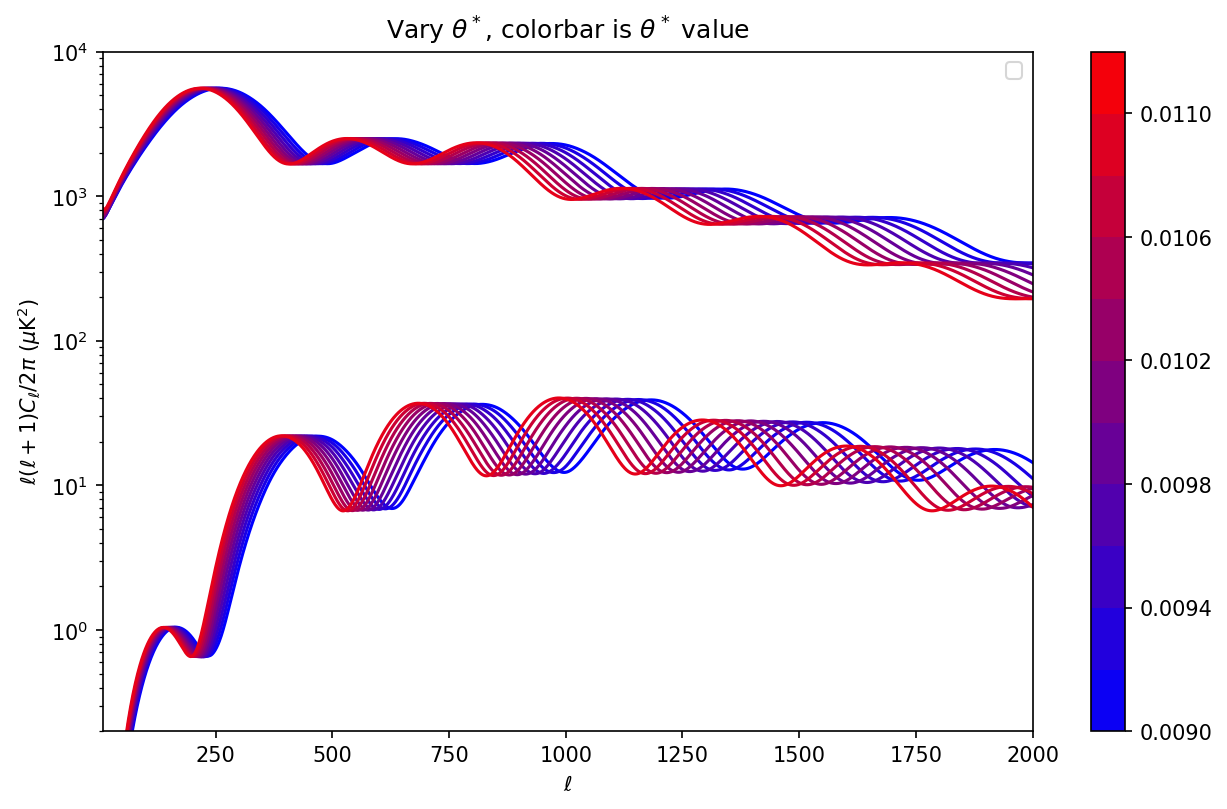

In [9]:
# step through theta star 
min_par = 0.9e-2
max_par = 1.1e-2
stepsize = 0.2e-3
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])

# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = np.arange(min_par,max_par+stepsize,stepsize)
plt.figure(figsize= (10,6), dpi = 150)
CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()
# real plotting start here. 
for par in np.arange(min_par, max_par, stepsize):
    camb_results = calculate_cmb(thetastar = par, H0=None)
    totCL = camb_results['power']['total']
    refCL = camb_results['results'].get_lensed_scalar_cls(CMB_unit='muK')
    r = (par-min_par)/(max_par-min_par)
    g = 0
    b = 1-r
    ells = np.arange(len(totCL[:,0]))
    plt.semilogy(ells,totCL[:,0], color=(r, g, b) )
    plt.semilogy(ells,totCL[:,1], color=(r, g, b) )
plt.colorbar(CS3)
plt.axis([8,2000, 2e-1, 1e4])
plt.legend(ncol=2, loc='best')
plt.title('Vary $\\theta ^*$, colorbar is $\\theta ^*$ value')
plt.xlabel('$\ell$' )
plt.ylabel('$\ell (\ell+1) C_\ell / 2\pi$ ($\mu$K$^2$)')

## Hubble constant

Now we have went through the six $\Lambda CDM$ parameters. Now we go to some additional ones. Hubble constant can be determine by the CMB with the assumption that the universe is flat. We can see the effect of Hubble constant is similar to the effect of spatial curvature, or $\Omega_K$. 

Under the assumption that the universe is flat ($\Omega_K =0$), or $\Omega_c + \Omega_{\Lambda} =1$, a constraint on $H_0$ can be obtained. 

<img src="omega_m_omega_lambda.png" alt="Drawing" style="width: 400px;"/>

Credit: WMAP3

No handles with labels found to put in legend.


Text(0, 0.5, '$\\ell (\\ell+1) C_\\ell / 2\\pi$ ($\\mu$K$^2$)')

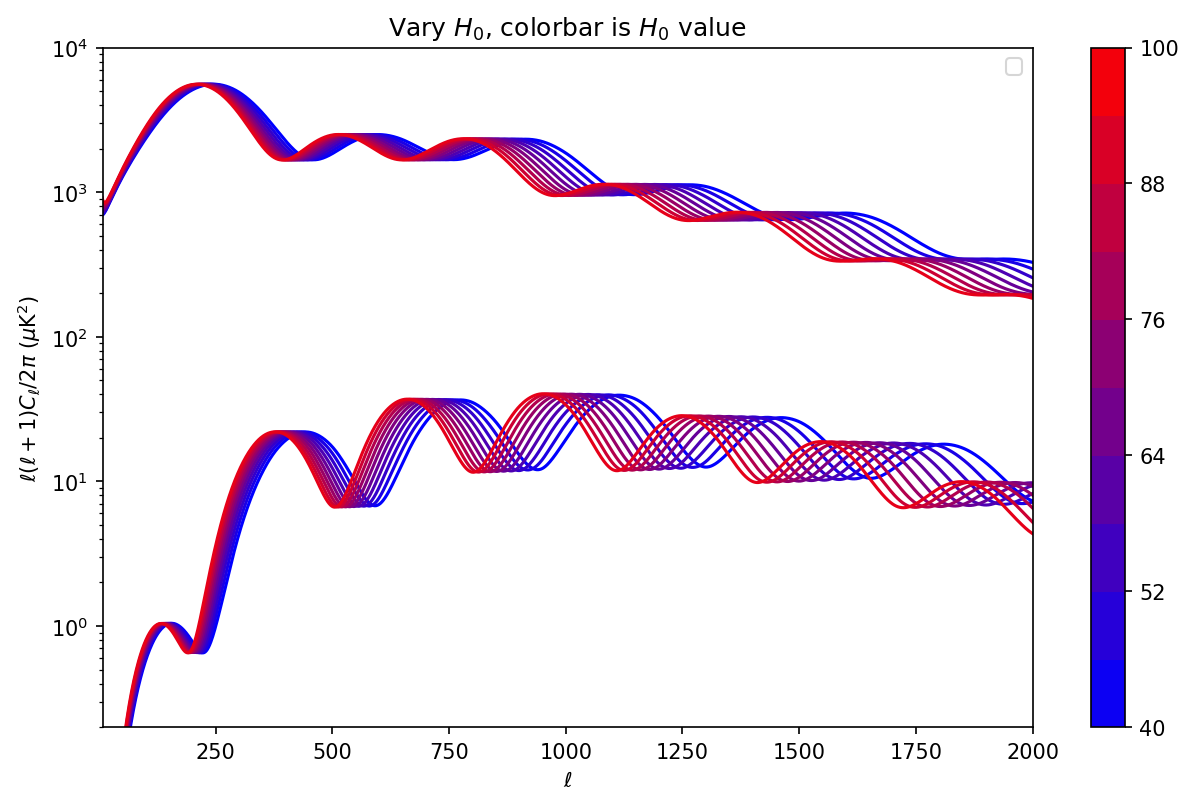

In [10]:
# step through Hubble constant
min_par = 40
max_par = 100
stepsize = 6
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])

# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = np.arange(min_par,max_par+stepsize,stepsize)
plt.figure(figsize= (10,6), dpi = 150)
CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()
# real plotting start here. 
for par in np.arange(min_par, max_par, stepsize):
    camb_results = calculate_cmb(H0=par)
    totCL = camb_results['power']['total']
    refCL = camb_results['results'].get_lensed_scalar_cls(CMB_unit='muK')
    r = (par-min_par)/(max_par-min_par)
    g = 0
    b = 1-r
    ells = np.arange(len(totCL[:,0]))
    plt.semilogy(ells,totCL[:,0], color=(r, g, b) )
    plt.semilogy(ells,totCL[:,1], color=(r, g, b) )
plt.colorbar(CS3)
plt.axis([8,2000, 2e-1, 1e4])
plt.legend(ncol=2, loc='best')
plt.title('Vary $H_0$, colorbar is $H_0$ value')
plt.xlabel('$\ell$' )
plt.ylabel('$\ell (\ell+1) C_\ell / 2\pi$ ($\mu$K$^2$)')

## Alens

$A_{lens}$ is the lensing amplitude. Increasing $A_{lens}$ will increase the deflection of CMB photons. More $A_{lens}$ causes the power spectra to be less sharp because power is shoved around by lensing coupling of different modes. 

No handles with labels found to put in legend.


Text(0, 0.5, '$\\ell (\\ell+1) C_\\ell / 2\\pi$ ($\\mu$K$^2$)')

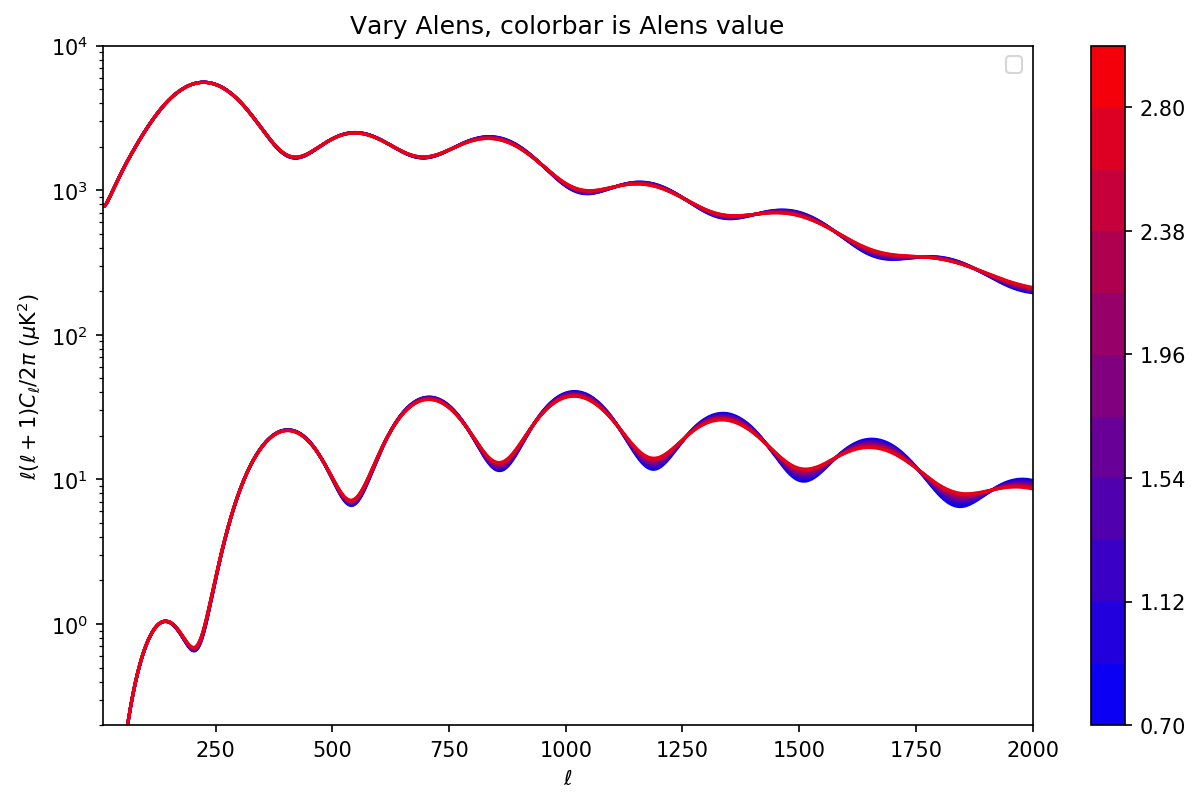

In [11]:
# step through Alens
min_par = 0.7
max_par = 3.0
stepsize = 0.21
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])

# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = np.arange(min_par,max_par+stepsize,stepsize)
plt.figure(figsize= (10,6), dpi = 150)
CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()
# real plotting start here. 
for par in np.arange(min_par, max_par, stepsize):
    camb_results = calculate_cmb(Alens=par)
    totCL = camb_results['power']['total']
    refCL = camb_results['results'].get_lensed_scalar_cls(CMB_unit='muK')
    r = (par-min_par)/(max_par-min_par)
    g = 0
    b = 1-r
    ells = np.arange(len(totCL[:,0]))
    plt.semilogy(ells,totCL[:,0], color=(r, g, b) )
    plt.semilogy(ells,totCL[:,1], color=(r, g, b) )
plt.colorbar(CS3)
plt.axis([8,2000, 2e-1, 1e4])
plt.legend(ncol=2, loc='best')
plt.title('Vary Alens, colorbar is Alens value')
plt.xlabel('$\ell$' )
plt.ylabel('$\ell (\ell+1) C_\ell / 2\pi$ ($\mu$K$^2$)')

## Sum of neutrino mass
Neutrino mass will affect lensing part. The more neutrino there are, the more growth of structure will be suppressed. This is because neutrino act like radiation (which suppresses growth of structure) at earlier times and dark matter at later times. More neutrinos will cause less lensing, and there fore less lensing B-mode (not a very sensitive probe) and smaller lensing power spectrum (a better probe, but not shown). 

Text(0, 0.5, '$\\ell (\\ell+1) C_\\ell / 2\\pi$ ($\\mu$K$^2$)')

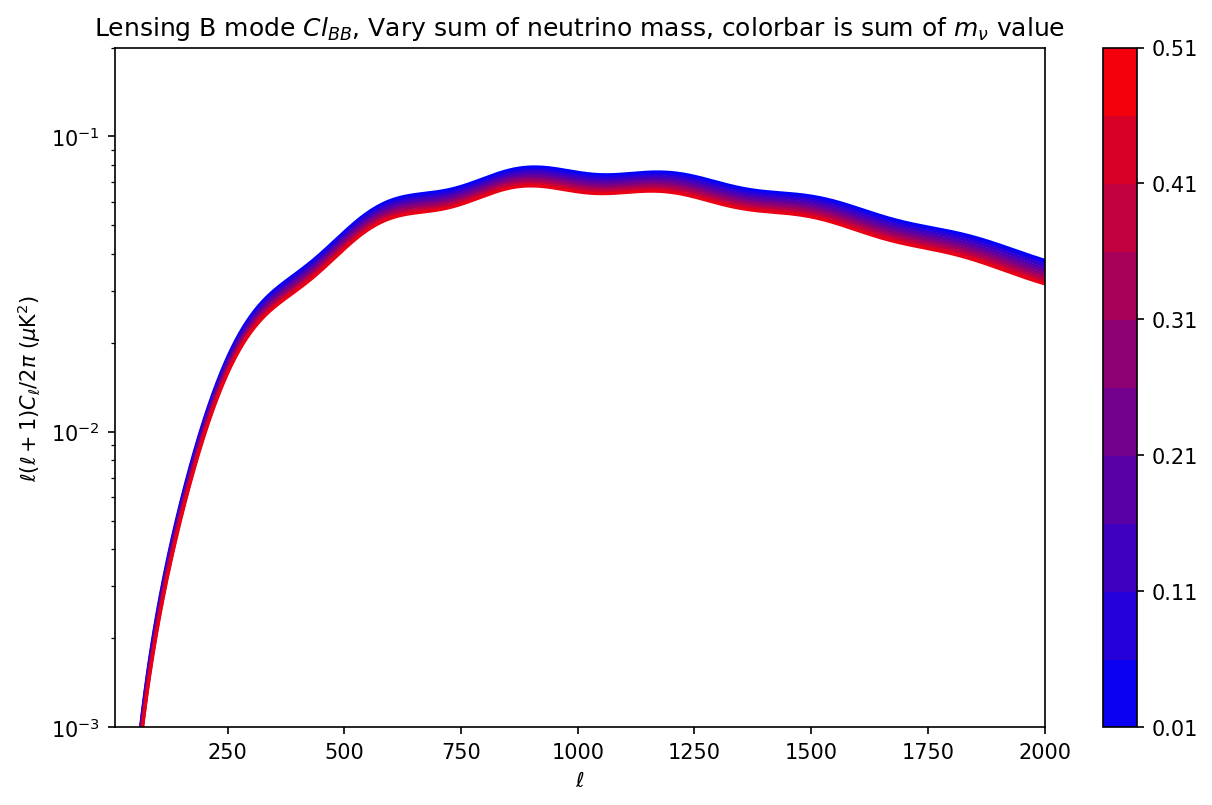

In [12]:
# step through m_nu
min_par = 0.01
max_par = 0.5
stepsize = 0.05
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])

# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = np.arange(min_par,max_par+stepsize,stepsize)
plt.figure(figsize= (10,6), dpi = 150)
CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()
# real plotting start here. 
for par in np.arange(min_par, max_par, stepsize):
    camb_results = calculate_cmb(mnu=par)
    totCL = camb_results['power']['total']
    refCL = camb_results['results'].get_lensed_scalar_cls(CMB_unit='muK')
    r = (par-min_par)/(max_par-min_par)
    g = 0
    b = 1-r
    ells = np.arange(len(totCL[:,0]))
    plt.semilogy(ells,refCL[:,2], color=(r, g, b) )
plt.colorbar(CS3)
plt.axis([8,2000, 1e-3, 2e-1])
#plt.legend(ncol=2, loc='best')
plt.title('Lensing B mode $Cl_{BB}$, Vary sum of neutrino mass, colorbar is sum of $m_{\\nu}$ value')
plt.xlabel('$\ell$' )
plt.ylabel('$\ell (\ell+1) C_\ell / 2\pi$ ($\mu$K$^2$)')

## Tensor to scalar ratio
Tensor perturbation can generate primordial gravitational waves, which inprint in the CMB as the inflationary B-modes. Inflationary B-mode will increase as the tensor-to-scalar ratio increase. 

Text(0, 0.5, '$\\ell (\\ell+1) C_\\ell / 2\\pi$ ($\\mu$K$^2$)')

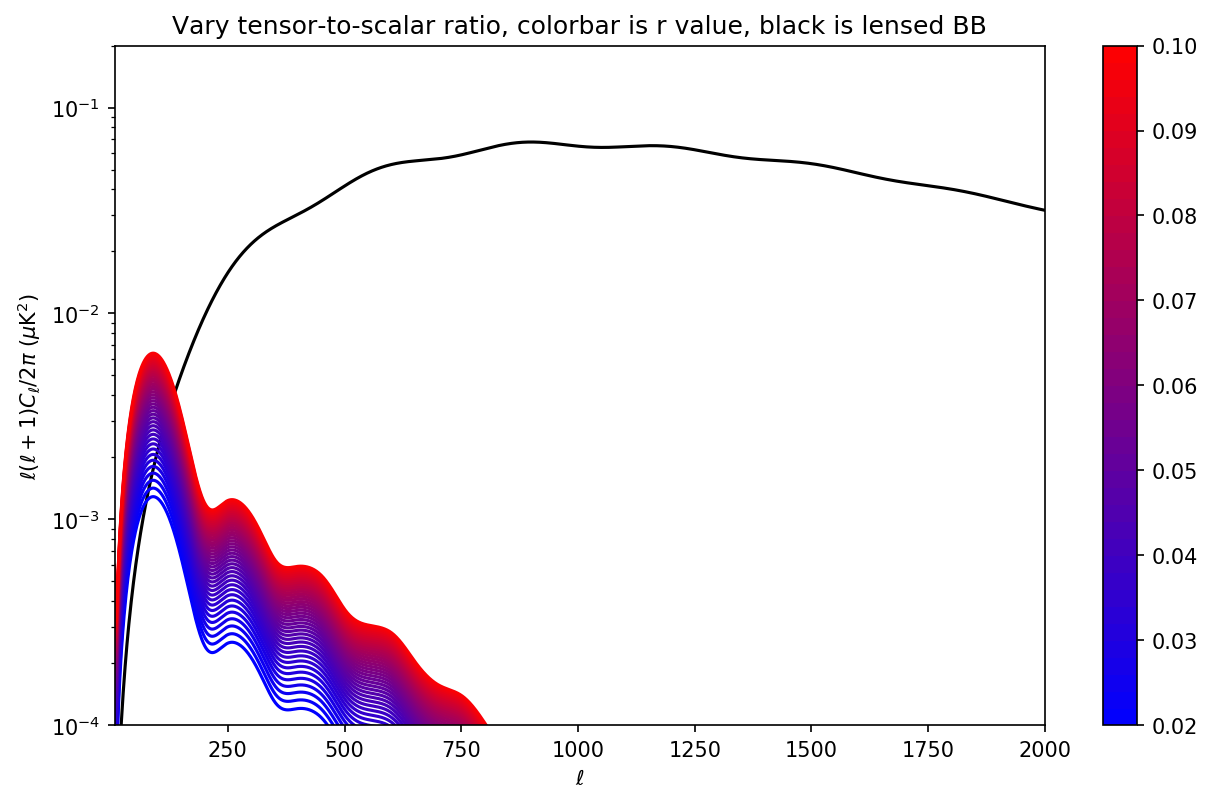

In [13]:
# step through r
min_par = 0.02
max_par = 0.1
stepsize = 0.002
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])

plt.figure(figsize= (10,6), dpi = 150)
camb_results = calculate_cmb(mnu=par)
refCL = camb_results['results'].get_lensed_scalar_cls(CMB_unit='muK')

# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = np.arange(min_par,max_par+stepsize,stepsize)

CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()
plt.semilogy(np.arange(len(refCL[:,2])),refCL[:,2], color='k' )

# real plotting start here. 
for par in np.arange(min_par, max_par, stepsize):
    tensor_cl = calculate_tensor(pars=camb_results['pars'], ns=0.965, r=par, lmax=3000)
    r = (par-min_par)/(max_par-min_par)
    g = 0
    b = 1-r
    ells = np.arange(len(tensor_cl[:,0]))
    plt.semilogy(ells,tensor_cl[:,2], color=(r, g, b) )
plt.colorbar(CS3)
plt.axis([8,2000, 1e-4, 2e-1])
#plt.legend(ncol=2, loc='best')
plt.title('Vary tensor-to-scalar ratio, colorbar is r value, black is lensed BB')
plt.xlabel('$\ell$' )
plt.ylabel('$\ell (\ell+1) C_\ell / 2\pi$ ($\mu$K$^2$)')